# Analysis of Apple Watches

The [Apple website](https://www.apple.com/watch/compare/) shows all available Apple Watch models with their features. We scrape this information.

In [1]:
import httpx
from bs4 import BeautifulSoup

r = httpx.get("https://www.apple.com/watch/compare/")
html_doc = r.text
soup = BeautifulSoup(html_doc, "html.parser")
devices_html = soup.find_all("div", class_="device-content with-list-bullet")

We extract the features and store them with the watch models in `Watch` objects.

Later we want to match features between differen watch models. For this purpose we define a linear order on the watches: A watch is considered "smaller" if it has less features than the other watch. If they have both the same number of features, the watch the the alphabetical smaller name is considered smaller.

In [2]:
from collections import defaultdict
from pprint import pprint
from typing import List

from attrs import define
from pyrsistent import PVector
from pyrsistent import pvector


@define(frozen=True)
class Watch:
    name: str
    features: PVector

    def __lt__(self, other: "Watch") -> bool:
        if len(self.features) < len(other.features):
            return True
        if (len(self.features) == len(other.features)) and (self.name < other.name):
            return True
        return False


watches = []

for device in devices_html:
    watches.append(
        Watch(
            name=device.h3.text,
            features=pvector(li.text for li in device.find_all("li")),
        )
    )

watches.sort()
pprint([(_.name, len(_.features)) for _ in watches])

[('Apple\xa0Watch Series\xa0 1', 11),
 ('Apple\xa0Watch Series\xa02', 13),
 ('Apple\xa0Watch SE', 14),
 ('Apple\xa0Watch Series\xa03', 14),
 ('Apple\xa0Watch Series\xa04', 14),
 ('Apple\xa0Watch Series\xa05', 14),
 ('Apple\xa0Watch Series\xa06', 14),
 ('Apple\xa0Watch\xa0SE (1st\xa0generation)', 14),
 ('Apple\xa0Watch Series\xa07', 15),
 ('Apple\xa0Watch Series\xa08', 16),
 ('Apple\xa0Watch\xa0Ultra', 16)]


The features are written as free text. While the same feature uses the same text, it's harder to find what feature of a newer model matches to which feature of an older model.

Using an NLP model from [huggingface](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) we compute embeddings for the features of all watches.

In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = defaultdict()

for watch in watches:
    # print(watch.name)
    embeddings[watch] = model.encode(watch.features, convert_to_tensor=True)

In [4]:
import itertools
from collections import Counter
from typing import Dict

import torch
from sentence_transformers import util


def dd():
    return defaultdict(dd)


def derive_mappings(matrix: torch.Tensor) -> Dict[int, int]:
    l1, l2 = matrix.size()
    maxs, indices = torch.max(matrix, dim=1)
    naive_map = {i: indices[i].item() for i in range(l1)}
    # pprint(naive_map)
    if max((vals := (c := Counter(naive_map.values())).values())) > 1:
        # print(c)
        _too_complicated = f"Too complicated: {c}"
        if len(dups := [_ for _ in c if c[_] > 1]) > 1:
            raise ValueError("More than one conflict. " + _too_complicated)
        target = dups[0]
        if c[target] > 2:
            raise ValueError(
                "More than two features point to same feature. " + _too_complicated
            )
        # print(f"{dups=}")
        features = [i for i in naive_map if naive_map[i] == dups[0]]
        i, j = features
        # print(i, j, maxs[i], maxs[j])
        if maxs[i] > maxs[j]:
            i, j = j, i
        # target_2 = (row:=matrix[i].values()).index(max(v for v in row if v < maxs[i]))
        # print(target_2)
        val_2, target_2 = (top2 := matrix[i].topk(2)).values[1].item(), top2.indices[
            1
        ].item()
        if (
            len(
                [val for i in range(l1) if (val := matrix[i][target_2].item()) >= val_2]
            )
            > 1
        ):
            raise ValueError(
                f"Second best mapping for feature {i_2} is also a good (or better) mapping for other features. "
                + _too_complicated
            )
        if target_2 in vals:
            raise ValueError(
                f"New target {target_2} for feature {i_2} has already been mapped. "
                + _too_complicated
            )
        naive_map[i] = target_2
    return naive_map


scores = defaultdict(dd)
mappings = defaultdict(dd)

for (w1, w2) in itertools.combinations(watches, 2):
    assert w1 < w2
    scores[(w1, w2)] = (matrix := util.cos_sim(embeddings[w1], embeddings[w2]))
    mappings[(w1, w2)] = derive_mappings(matrix)

66 187
<class 'NoneType'>


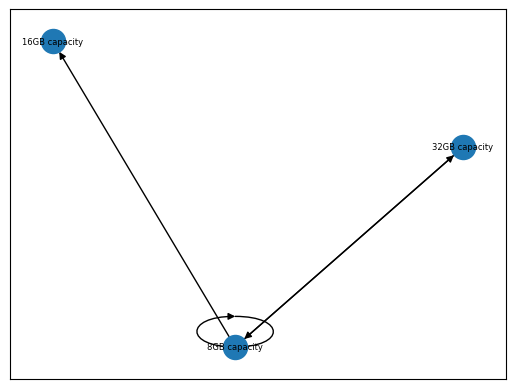

<class 'NoneType'>


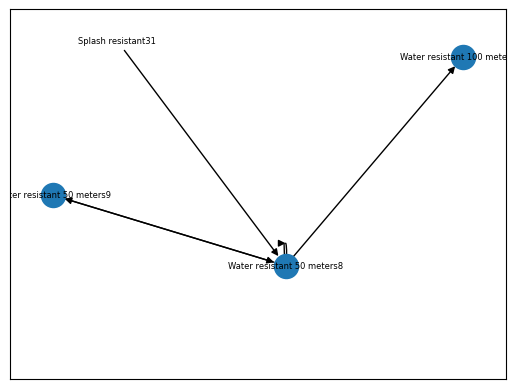

<class 'NoneType'>


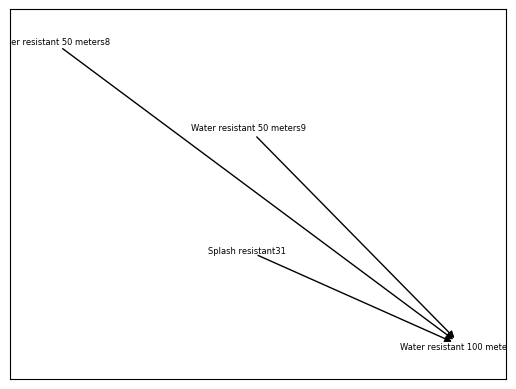

<class 'NoneType'>


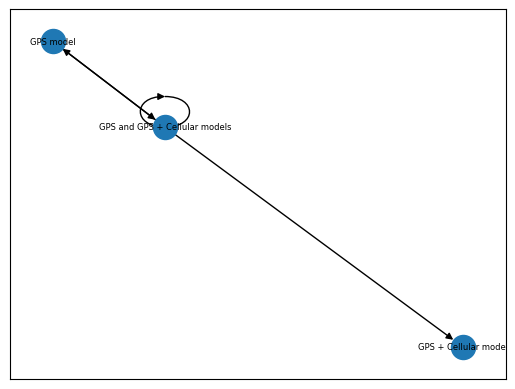

<class 'NoneType'>


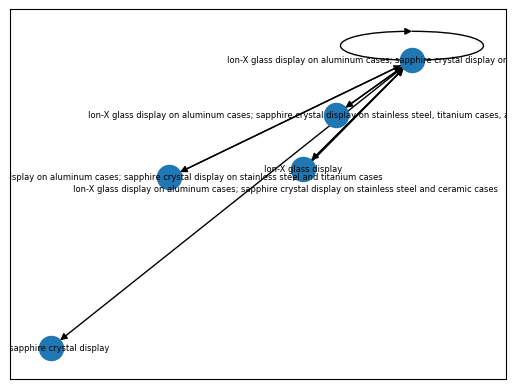

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx

features = set()
for w in watches:
    features |= set(w.features)
# pprint(features)
G = nx.DiGraph()
G.add_nodes_from(features)
edge_labels = {}
for (w1, w2) in itertools.combinations(watches, 2):
    for (s, t) in mappings[(w1, w2)].items():
        # print(w1.name, w2.name, s, t)
        G.add_edge(*(e:=w1.features[s], w2.features[t]))
        edge_labels[e]=(w1,w2)
print(G.number_of_nodes(), G.number_of_edges())
for (i,n) in enumerate(G.nodes()):
    # print(i,n)
    edgs = [_ for _ in G.edges if n in _]
    nghs = list(G.neighbors(n))
    nx.draw_networkx(G, nodelist = nghs, edgelist = edgs, font_size=6)
    nx.draw_networkx_edge_labels(G, nodelist = nghs, edgelist = edgs, edge_labels=edge_labels)
    # ax.set_axis_off()
    # fig.tight_layout()
    plt.show()
    if i > 3:
        break

In [19]:
2 in (2,3)

True

In [10]:
@define(frozen=True)
class FeatureNode:
    watch: Watch
    index: int

    def name(self):
        return watch.features[index]


feature_nodes = [
    FeatureNode(watch, index)
    for watch in watches
    for index in range(len(watch.features))
]
print(len(feature_nodes))

155


In [12]:
import networkx as nx

G = nx.Graph()

In [ ]:
import torch

argmax_vector = torch.argmax(matrix, dim=1)
for i in range(len(argmax_vector)):
    j = argmax_vector[i].item()
    if (s := matrix[i][j].item()) < 0.999:
        print(i, j, s, features[first][i], "|", features[second][j])

In [ ]:
argmax_vector = torch.argmax(matrix, dim=0)
for j in range(len(argmax_vector)):
    i = argmax_vector[j].item()
    if (s := matrix[i][j].item()) < 0.999:
        print(i, j, s, features[first][i], "|", features[second][j])

In [ ]:
print("|", (one := features[first][14]), "|", (two := features[second][13]), "|")
print(one == two)

In [ ]:
import itertools

print(len(key_list))
pprint(combs := list(itertools.combinations(key_list, 2)))
print(len(combs))

In [54]:
t = torch.Tensor([[1, -7, 3], [8, -15, 6]])
print(t)
print(t.size())

tensor([[  1.,  -7.,   3.],
        [  8., -15.,   6.]])
torch.Size([2, 3])


In [58]:
max(_ for _ in t[0] if _ < 5).item()

3.0

In [ ]:
torch.max(t, dim=0)

In [ ]:
torch.max(t, dim=1)

In [ ]:
torch.argmax(t, dim=0)

In [ ]:
torch.argmax(t, dim=1)

In [ ]:
torch.max(t)

In [ ]:
torch.argmax(t)

In [ ]:
a = [2, 1, 3]
pprint(sorted(a))
pprint(a.sort())
pprint(a)